In [6]:
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from modules_gd.model import VAE
from modules_gd.data import MSA_Dataset

## Inspect the pre-processed MSA

In [28]:
MSA_id = "PF00565"
query_seq_id = "SND1_HUMAN/552-660"
data_path = f"data/Ding/processed/{MSA_id}"

In [29]:
!echo Total number of sequences:
! wc -l {data_path}/seq_msa_char.txt 
!echo Check that query sequence present:
! grep {query_seq_id} {data_path}/seq_msa_char.txt 
#!echo Check that outgroup sequence present:
#! grep {outgroup_acc} {data_path}/seq_msa_char.txt
!echo Print first 25 sequences:
! head -n 25 {data_path}/seq_msa_char.txt 

Total number of sequences:
    7162 data/Ding/processed/PF00565/seq_msa_char.txt
Check that query sequence present:
SND1_HUMAN/552-660	GIECPRGAEPFSEEATLFTKELVLQREVEVEVESMDKAGNFIGWLHIDGANLSVLLVEHALSKVHFTAERSSYYKSLLSAEEAAKQKKEKVWA
Print first 25 sequences:
A0A3P7MX59_9BILA/1-72	....................................SNQNFVGSVIHPKGNIAELLLNEGFAKCVDWSIATSGPEVLRAAEKRAKDKKLRLWR
A0A4W6CL59_LATCA/173-263	....................................YSGATCPHVTIQKDDVGLGLVKEGLVMVDIRKELQKMVTEYLNSQESAKSARLNIWR
A0A0Q3PK25_AMAAE/1-60	...................................DKAGNFIGWLHTEGLNLSVALVEHALSKVHFTAERSPYYKALLAAEEAAKQKKEKVWS
A0A151P0H3_ALLMI/1-60	...................................DKAGNFIGWLHVDGANLSVSLVEQALSKVHFTAERSPYYKALLSAEEAAKQRKEKVWS
A0A1V4JH04_PATFA/1-60	...................................DKAGNFIGWLHVDGLNLSVALVEQALSKVHFTAERSPYYKALVAAEEGAKQRKEKVWS
A0A2U3YW32_LEPWE/1-60	...................................DKAGNFIGWLHIDSANLSVLLVEHALSKVHFTAERSSYYKSLLSAEEAAKQKKEKVWA
A0A7J8HDF3_MOLMO/1-60	........................

## Load data and instantiate dataset

In [30]:
## read in binary representation of MSA
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([7161, 93, 21])

In [8]:
## each sequence has a label
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
seq_names[:10]

['TENA_HUMAN/804-884',
 'A0A1V4K5D5_PATFA/585-645',
 'A0A8I5N0T3_PAPAN/1664-1744',
 'A0A8C9LI62_9PRIM/579-667',
 'A0A671K1Y1_9TELE/822-901',
 'A0A8C9XQA9_SANLU/809-899',
 'A0A672I963_SALFA/90-173',
 'A0A6P7I4P6_9TELE/710-790',
 'A0A6J1R157_9HYME/1216-1302',
 'A0A8C3Y235_CATUS/1543-1624']

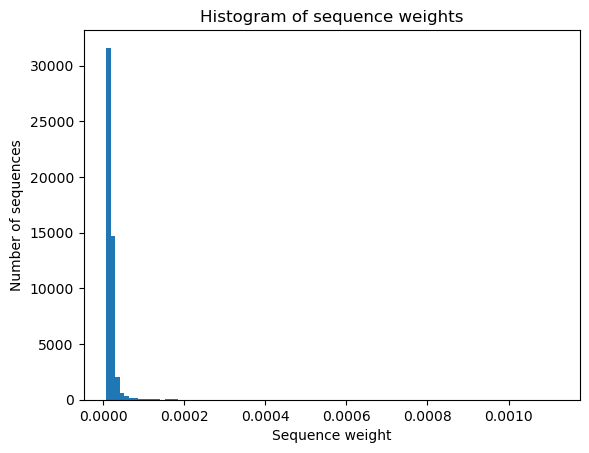

In [11]:
## sequences in msa are weighted
with open(f"{data_path}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
# make a histogram of seq_weight
import matplotlib.pyplot as plt
plt.hist(seq_weight, bins=100)
plt.xlabel('Sequence weight')
plt.ylabel('Number of sequences')
plt.title('Histogram of sequence weights')
plt.show()
# assert that the sum of the weights is approximately 1
assert np.abs(seq_weight.sum()-1) < 1e-6
# If you want to have equal weight for each sequence, run this code
# seq_weight = np.ones_like(seq_weight)/n_seq

In [12]:
data = MSA_Dataset(msa_binary, seq_weight, seq_names)
# Show a random example
data[1]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 6.48563e-05,
 'A0A1V4K5D5_PATFA/585-645')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [13]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc, dim_latent_vars = 2)

Let's check that our model processes data the way we want it to

In [14]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[ 0.0601, -0.0120]], grad_fn=<AddmmBackward0>), tensor([[0.9535, 1.0480]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 71, 21]) and is given by:
tensor([[[-2.9809, -3.1083, -2.9295,  ..., -3.0605, -3.0717, -2.9804],
         [-2.9877, -2.9547, -3.1076,  ..., -2.9987, -3.0835, -3.0423],
         [-2.9795, -3.0554, -2.8889,  ..., -3.1213, -3.1191, -2.9343],
         ...,
         [-3.0022, -2.9703, -2.9190,  ..., -3.0059, -3.0813, -3.0628],
         [-3.1775, -3.0473, -3.0446,  ..., -3.0474, -3.0854, -3.0696],
         [-3.0433, -2.9542, -3.0192,  ..., -3.0685, -2.8698, -3.0473]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0507, 0.0447, 0.0534,  ..., 0.0469, 0.0463, 0.0508],
        [0.0504, 0.0521, 0.0447,  ..., 0.0499, 0.0458, 0.0477],
        [0.0508, 0.0471, 0.0556,  ..., 0.0441, 0.0442, 0.0532],
        ...,
        [0.0497, 0.0513, 0.0540,  ..., 0.0495, 

## Train model

In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
num_epochs = 25
#wd = .01
dim_lat = 10
bs = 128
verbose = False

cpu


In [16]:
# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_elbo = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    elbo_scalar = -loss.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, elbo_scalar), \
            flush = True)
    running_elbo.append(elbo_scalar)

  return running_elbo

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100) # how many samples to use for IWAE estimate of ELBO
      elbo_scalar = torch.mean(elbo).item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, _ = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



In [17]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(data)), test_size = 0.1, random_state = 42)
train_loader = DataLoader(data, batch_size = bs, sampler = torch.utils.data.SubsetRandomSampler(train_idx))
test_loader = DataLoader(data, batch_size = bs, sampler = torch.utils.data.SubsetRandomSampler(test_idx))

In [18]:
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
optimizer = optim.Adam(model.parameters()) # optionally include `weight_decay = wd` in the optimizer

train_elbos = []
test_elbos = []
test_recon_accs = []
for epoch in range(num_epochs):
  batch_elbos, batch_recon_accs = eval(model, device, test_loader, recon = True)
  epoch_test_elbo, epoch_test_recon_acc = np.mean(batch_elbos), np.mean(batch_recon_accs)
  test_elbos.append(epoch_test_elbo)
  test_recon_accs.append(epoch_test_recon_acc)
  print(f"Test elbo for epoch {epoch}: {epoch_test_elbo}")
  print(f"Test reconstruction accuracy for fold epoch {epoch}: {epoch_test_recon_acc}")
  batch_elbos = train(model, device, train_loader, optimizer, epoch, verbose)
  epoch_train_elbo = np.mean(batch_elbos)
  train_elbos.append(epoch_train_elbo)
  print(f"Training elbo for epoch {epoch}: {epoch_train_elbo}")
  

Test elbo for epoch 0: -216.6502850423109
Test reconstruction accuracy for fold epoch 0: 0.04756350601091981
Training elbo for epoch 0: -160.599551894448
Test elbo for epoch 1: -150.50661791103371
Test reconstruction accuracy for fold epoch 1: 0.3518922097980976
Training elbo for epoch 1: -150.20946593718097
Test elbo for epoch 2: -141.21735606299666
Test reconstruction accuracy for fold epoch 2: 0.3947356015443802
Training elbo for epoch 2: -143.1245312690735
Test elbo for epoch 3: -134.7477127733258
Test reconstruction accuracy for fold epoch 3: 0.4258280128240585
Training elbo for epoch 3: -137.47088605707341
Test elbo for epoch 4: -128.74303134555788
Test reconstruction accuracy for fold epoch 4: 0.45629912465810774
Training elbo for epoch 4: -132.34147355773231
Test elbo for epoch 5: -124.71082489931098
Test reconstruction accuracy for fold epoch 5: 0.47111890017986296
Training elbo for epoch 5: -128.3542887947776
Test elbo for epoch 6: -121.06051648278648
Test reconstruction accu

In [20]:
# Save model
from datetime import date
import os
os.makedirs(f"saved_models/{MSA_id}", exist_ok = True)
model.cpu()
today = date.today()
torch.save(model.state_dict(), f"saved_models/{MSA_id}/model_ld10_wd0_epoch25_{today}.pt")

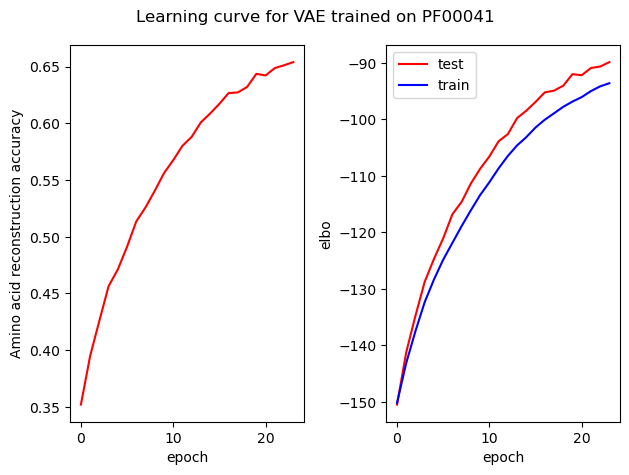

In [19]:
# plot learning curve
fig, axs = plt.subplots(1, 2)

axs[0].plot(test_recon_accs[1:], color = 'r')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel(f"Amino acid reconstruction accuracy")

axs[1].plot(test_elbos[1:], label = "test", color = 'r')
axs[1].plot(train_elbos[1:], label = "train", color = 'b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel(f"elbo")
axs[1].legend()

# add title
plt.suptitle(f"Learning curve for VAE trained on {MSA_id}")
plt.tight_layout()


There are two possible reasons why the training elbo is lower than the test elbo:
1. The training elbo is computed with weights (since during training, we want to make the model pay more attention to less typical sequences).
2. The test ELBO is computed with `compute_elbo_with_multiple_samples`, which computes an IWAE estimate of the marginal likelihood, which, recall, should be greater than the ELBO.

If the training ELBO at all exceeds the test ELBO, I think that's a good sign that there's over fitting.